In [1]:
import pandas as pd
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from copy import deepcopy
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from torch.optim.lr_scheduler import StepLR
import seaborn as sns
# import wfdb
# from wfdb import processing
import random
from scipy import signal
from torchvision import transforms
torch.manual_seed(124)
random.seed(124)
np.random.seed(124)

# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
#Loading Training Data
train_data = pd.read_csv('mitbih_train.csv')

### VISUALIZATION

In [3]:
#Preview Training Data
row_no, col_no = train_data.shape
print(f'There are {row_no} rows and {col_no} columns')

There are 87553 rows and 188 columns


In [4]:
#Targets
y_df = train_data.iloc[:, -1]
y_df.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: 0.000000000000000000e+00.88, dtype: float64

In [5]:
#Convert to Int
y_df = y_df.astype('int')
y_df.head()

0    0
1    0
2    0
3    0
4    0
Name: 0.000000000000000000e+00.88, dtype: int32

In [6]:
#Features
X_df = train_data.iloc[:, :-1]
X_df.head()

,9.779411554336547852e-01,9.264705777168273926e-01,6.813725233078002930e-01,2.450980395078659058e-01,1.544117629528045654e-01,1.911764740943908691e-01,1.519607901573181152e-01,8.578431606292724609e-02,5.882352963089942932e-02,4.901960864663124084e-02,...,0.000000000000000000e+00.78,0.000000000000000000e+00.79,0.000000000000000000e+00.80,0.000000000000000000e+00.81,0.000000000000000000e+00.82,0.000000000000000000e+00.83,0.000000000000000000e+00.84,0.000000000000000000e+00.85,0.000000000000000000e+00.86,0.000000000000000000e+00.87
0,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.927461,1.000000,0.626943,0.193437,0.094991,0.072539,0.043178,0.053541,0.093264,0.189983,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
#Check each class counts
unique, count = np.unique(y_df, return_counts=True)
print(f'unique values: {unique}')
print(f'counts: {count}')

unique values: [0 1 2 3 4]
counts: [72470  2223  5788   641  6431]


<BarContainer object of 5 artists>

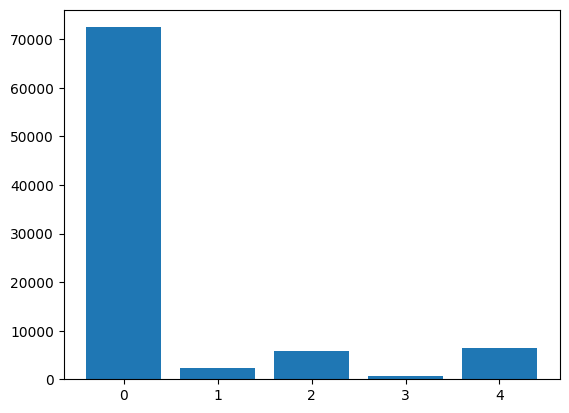

In [8]:
plt.bar(unique,count)

In [9]:
#Assign class names using dictionary
#Data Source: Physionet's MIT-BIH Arrhythmia Dataset
#Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]
class_names = {0: 'N', 1: 'S', 2: 'V', 3: 'F', 4: 'Q'}

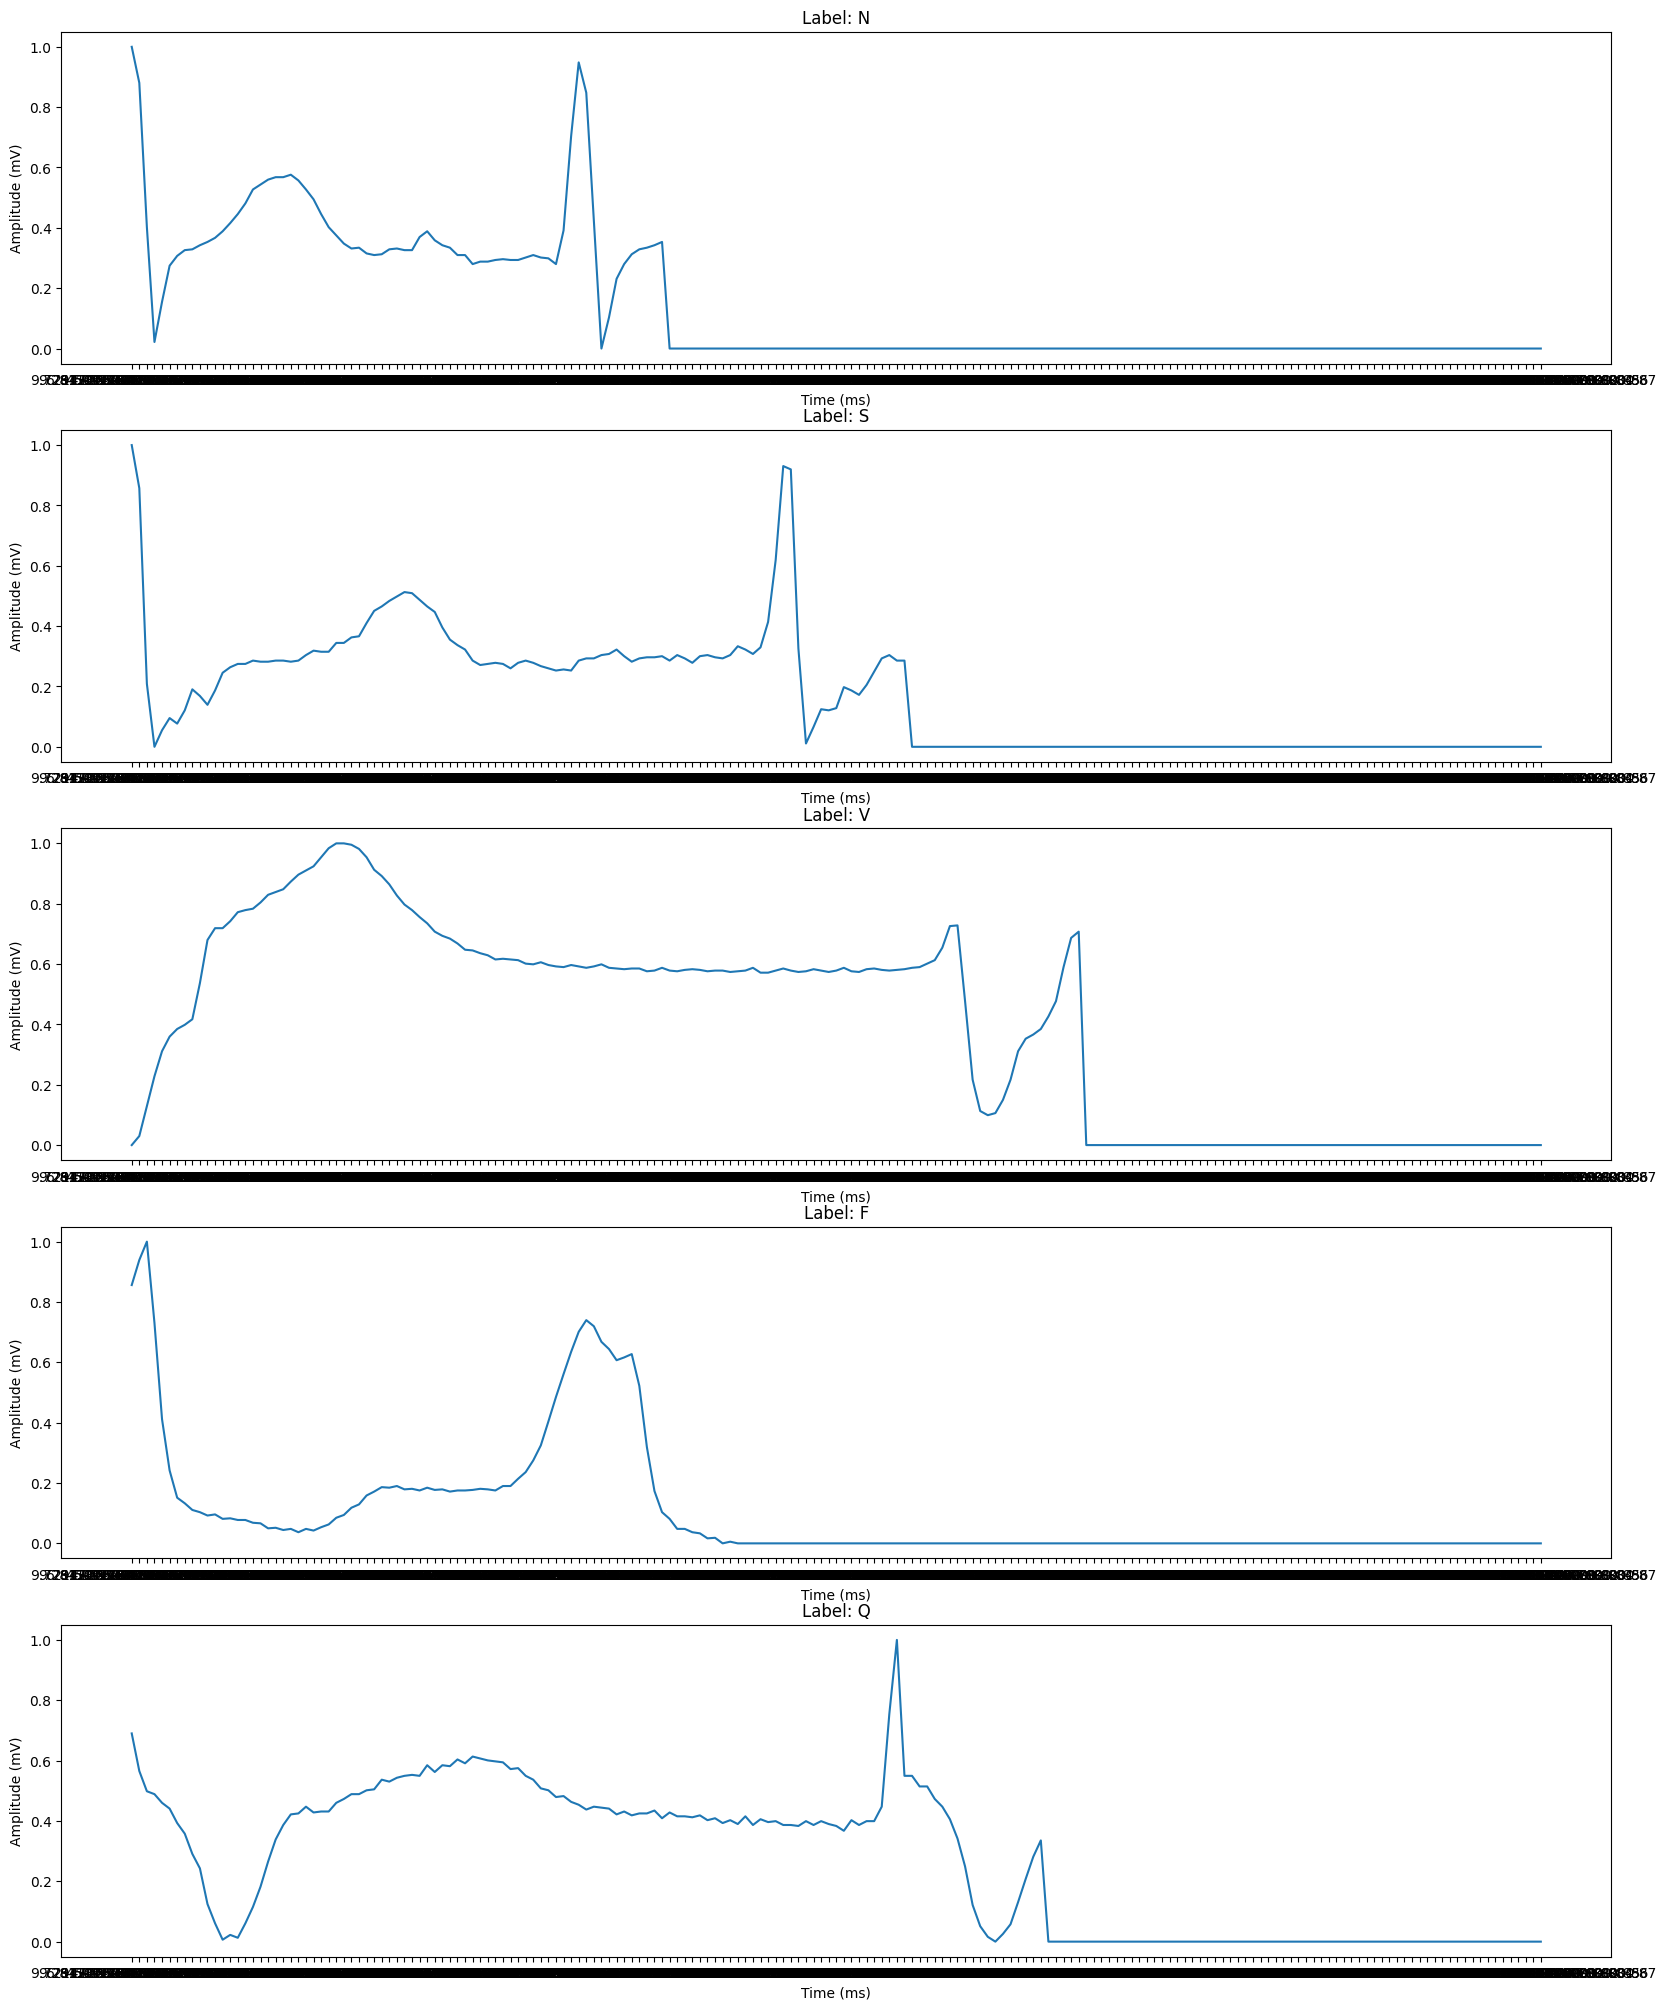

In [10]:
#Preview Class N ECG Shape
fig, ax = plt.subplots(5, 1, figsize=(20, 25))

for i in range(5):
    ax[i].plot(X_df.loc[y_df[y_df == i].sample().index[0]])
    ax[i].set_title(f'Label: {class_names[i]}')
    ax[i].set_xlabel('Time (ms)')
    ax[i].set_ylabel('Amplitude (mV)')

In [43]:
#Convert to numpy
X_np = X_df.to_numpy()
y_np = y_df.to_numpy()

In [44]:
#Check X_np dimension
X_np.shape

(87553, 187)

In [45]:
#Reshaping X_np
X_np = X_np.reshape(-1, 1, 187)

In [46]:
#Check new dimension of X_np
X_np.shape

(87553, 1, 187)

In [47]:
#Check y_np dimension
y_np.shape

(87553,)

In [49]:
#Reshaping y_np
y_np = y_np.reshape(-1, 1)

In [50]:
#Check new dimension of y_np
y_np.shape

(87553, 1)

In [54]:
print(f'X_np std is {X_np.std()}')

X_np std is 0.22632775223268004


For better model performance, we will be normalizing X_np.

In [52]:
X_mean = X_np.mean()
X_std = X_np.std()
X_max = X_np.max()
X_min = X_np.min()

In [53]:
X_norm = X_np - X_mean
X_norm *= 1/X_std

In [60]:
print(f'X_norm std is {X_norm.std()}')

X_norm std is 0.9999999999999998


Now we start splitting the data and do a bit of augmentation to balance the classes, because as seen from the class distribution graph from before, samples in Class 1 and 3 are signficantly less than 2 and 4.

In [5]:
np.array([[1,2],[3,4],[5,6]]).reshape(-1, 1, 2)

array([[[1, 2]],

       [[3, 4]],

       [[5, 6]]])

### DATALOADING

In [3]:
class ECGDataset(torch.utils.data.Dataset):
    def __init__(self, train_data_x, train_data_y, transform=None):
        # Whole data as a pandas array
        self.transform = transform
        self.data = np.concatenate((train_data_x, train_data_y.reshape(-1, 1)), axis=1)
        self.dataset_length = len(self.data)
        
        # Extract inputs
        self.input_fetaures_number = 187
        self.input_features = train_data_x.reshape(-1, 1, 187)
        
        # Extract outputs
        self.output_fetaures_number = 1
        self.output_feature = train_data_y
    
    def __getitem__(self, index):
        # Fetch inputs
        x = self.input_features[index]
        if self.transform:
            x = self.transform(x)
        # Fetch outputs
        y = self.output_feature[index]
        return x, y
    
    def __len__(self):
        return len(self.data)

In [4]:
# https://stackoverflow.com/questions/67799246/weighted-random-sampler-oversample-or-undersample
def undersample_weights(signals, nclasses):
    n_images = len(signals)
    # count_per_class = [0] * nclasses
    _, count_per_class = np.unique(signals[:, -1], return_counts=True)
    
    weight_per_class = [0.] * nclasses
    for i in range(nclasses):
        weight_per_class[i] = float(n_images) / float(count_per_class[i])

    weights = [0] * n_images
    for idx, image_class in enumerate(signals[:, -1]):
        weights[idx] = weight_per_class[int(image_class)]
    return weights

In [5]:
X_mean = train_data.iloc[:, :-1].to_numpy().mean()
X_std = train_data.iloc[:, :-1].to_numpy().std()
y_np = train_data.iloc[:, -1].to_numpy()

X_norm = train_data.iloc[:, :-1].to_numpy() - X_mean
X_norm *= 1/X_std

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y_np, test_size=0.2, shuffle=True)

In [7]:
transform_data = transforms.Compose([
    # transforms.ToTensor(),
    transforms.Normalize((X_mean,), (X_std,))
])

# Train Dataloader
ecg_train_dataset = ECGDataset(X_train, y_train) #, transform=transform_data)

train_weights = torch.DoubleTensor(undersample_weights(ecg_train_dataset.data, 5))
train_sampler = torch.utils.data.WeightedRandomSampler(train_weights, len(train_weights))

ECG_train_dataloader = torch.utils.data.DataLoader(ecg_train_dataset, batch_size = 32, sampler=train_sampler)

# Test Dataloader
ecg_test_dataset = ECGDataset(X_test, y_test) #, transform=transform_data)

test_weights = torch.DoubleTensor(undersample_weights(ecg_test_dataset.data, 5))
test_sampler = torch.utils.data.WeightedRandomSampler(test_weights, len(test_weights))

ECG_test_dataloader = torch.utils.data.DataLoader(ecg_test_dataset, batch_size = 32, sampler=test_sampler)

<BarContainer object of 5 artists>

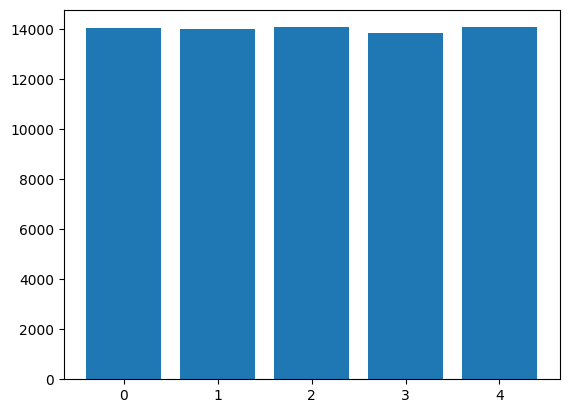

In [8]:
counts = [0] * 5
for batch_number, batch in enumerate(ECG_train_dataloader):
    inputs, outputs = batch
    # print(inputs.shape)
    # print(outputs.shape)
    # print("-----")
    for output in outputs:
        counts[int(output)] += 1
plt.bar([0,1,2,3,4], counts)

### MODEL

In [9]:
class ResidualBlock(nn.Module):
    def __init__(self, n):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(n[0], n[1], kernel_size = 3, stride = 1, padding = 1)
        print
        self.batch1 = nn.BatchNorm1d(n[1])
        # self.max1 = nn.MaxPool2d(n[1])

        self.conv2 = nn.Conv1d(n[1], n[2],  kernel_size = 3, stride = 1, padding = 1)
        self.batch2 = nn.BatchNorm1d(n[2])
        # self.max2 = nn.MaxPool2d(n[2])

    def forward(self, x):
        out = self.conv1(x.float())
        out = F.relu(self.batch1(out))
        # out = self.max1(out)

        out = self.conv2(out)
        out = F.relu(self.batch2(out))
        # out = self.max2(out)
        return out + x

In [10]:
class ECG_CNN(nn.Module):
    def __init__(self):
        super(ECG_CNN, self).__init__()
        # Two convolutional layers
        self.res1 = ResidualBlock([1, 64, 16])
        # self.res2 = ResidualBlock(32, 64, kernel_size = 3, stride = 1, padding = 1)
        # Two fully connected layers
        self.fc1 = nn.Linear(16*187, 128) # 64*28*28 = 50176
        self.fc2 = nn.Linear(128, 5)

    def forward(self, x):
        # Pass input through first convolutional layer
        x = self.res1(x)
        # Flatten output of second conv layer
        x = x.view(-1, 16*187)
        # Pass flattened output through first fully connected layer
        x = self.fc1(x.float())
        x = F.relu(x)
        # Pass output of first fully connected layer through second fully connected layer
        x = self.fc2(x)
        return x

In [11]:
def train(model, train_loader, test_loader, epochs = 10, lr = 0.001):
    # Use Adam optimizer to update model weights
    optimizer = optim.Adam(model.parameters(), lr = lr)
    # Use cross-entropy loss function
    criterion = nn.CrossEntropyLoss()
    # Performance curves data
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    
    for epoch in range(epochs):
        # Set model to training mode
        model.train()
        # Initialize epoch loss and accuracy
        epoch_loss = 0.0
        correct = 0
        total = 0
        # Iterate over training data
        for batch_number, (inputs, labels) in enumerate(train_loader):
            # Get from dataloader and send to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            inputs = inputs.float()

            # Zero out gradients
            optimizer.zero_grad()
            # Compute model output and loss
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels.to(torch.int64))
            # Backpropagate loss and update model weights
            loss.backward()
            optimizer.step()
            # Accumulate loss and correct predictions for epoch
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            print(f'Epoch {epoch+1}/{epochs}, Batch number: {batch_number}, Cumulated accuracy: {correct/total}')
        # Calculate epoch loss and accuracy
        epoch_loss /= len(train_loader)
        epoch_acc = correct/total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        print(f'--- Epoch {epoch+1}/{epochs}: Train loss: {epoch_loss:.4f}, Train accuracy: {epoch_acc:.4f}')
        
        # Set model to evaluation mode
        model.eval()
        # Initialize epoch loss and accuracy
        epoch_loss = 0.0
        correct = 0
        total = 0
        # Iterate over test data
        for inputs, labels in test_loader:
            # Get from dataloader and send to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Compute model output and loss
            # (No grad computation here, as it is the test data)
            with torch.no_grad():
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels.to(torch.int64))
            # Accumulate loss and correct predictions for epoch
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        # Calculate epoch loss and accuracy
        epoch_loss /= len(test_loader)
        epoch_acc = correct/total
        test_losses.append(epoch_loss)
        test_accuracies.append(epoch_acc)
        print(f'--- Epoch {epoch+1}/{epochs}: Test loss: {epoch_loss:.4f}, Test accuracy: {epoch_acc:.4f}')
    
    return train_losses, train_accuracies, test_losses, test_accuracies

In [12]:
model = ECG_CNN().to(device)
train_losses, train_accuracies, test_losses, test_accuracies = train(model, \
                                                                     ECG_train_dataloader, \
                                                                     ECG_test_dataloader, \
                                                                     epochs = 3, \
                                                                     lr = 1e-3)

Epoch 1/3, Batch number: 0, Cumulated accuracy: 0.15625
Epoch 1/3, Batch number: 1, Cumulated accuracy: 0.1875
Epoch 1/3, Batch number: 2, Cumulated accuracy: 0.21875
Epoch 1/3, Batch number: 3, Cumulated accuracy: 0.3359375
Epoch 1/3, Batch number: 4, Cumulated accuracy: 0.35
Epoch 1/3, Batch number: 5, Cumulated accuracy: 0.3854166666666667
Epoch 1/3, Batch number: 6, Cumulated accuracy: 0.41517857142857145
Epoch 1/3, Batch number: 7, Cumulated accuracy: 0.44140625
Epoch 1/3, Batch number: 8, Cumulated accuracy: 0.4583333333333333
Epoch 1/3, Batch number: 9, Cumulated accuracy: 0.4875
Epoch 1/3, Batch number: 10, Cumulated accuracy: 0.4943181818181818
Epoch 1/3, Batch number: 11, Cumulated accuracy: 0.5104166666666666
Epoch 1/3, Batch number: 12, Cumulated accuracy: 0.5240384615384616
Epoch 1/3, Batch number: 13, Cumulated accuracy: 0.5357142857142857
Epoch 1/3, Batch number: 14, Cumulated accuracy: 0.5354166666666667
Epoch 1/3, Batch number: 15, Cumulated accuracy: 0.548828125
Epoch

### SPLIT

In [61]:
X_train, X_val, y_train, y_val = train_test_split(X_norm, y_np, test_size=0.2, shuffle=True)

In [64]:
class_counts = [np.sum(y_train == i) for i in range(1,5)]
#We want to ignore the normal case and just focus on the illness cases.

In [65]:
print(class_counts)

[1764, 4620, 506, 5104]


In [66]:
max_class_count = np.max(class_counts)

In [67]:
aug_counts = [max_class_count - count for count in class_counts]

In [71]:
transforms_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
])
for i in range(1,5):
    if aug_counts[i] > 0:
        

IndentationError: expected an indented block (448652307.py, line 8)